# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Predicting Hospital Readmission Rates for Diabetes
## CS109a: Introduction to Data Science



**Harvard University**<br/>
**Fall 2023**<br/>
**Team members**: Karim Gowani, Ryan McGillicuddy, Yaseen Mohmand, Steven Worthington


<hr style="height:2pt">

# Introduction

## i. About This Notebook

This notebook represents a summary of a series of exploratory analysis, wherein we attempt various approaches to classify X-ray images into 14 disease classes and a 'no finding' class. For an overview of the analytical sections of this notebook, please see the [Notebook Contents](#Notebook-Contents) index listed below this Introduction.

### i.i. A note about supporting notebooks

The code and results reported in this notebook are only a summary of the work completed for this project - they represent the final form of our analyses. Supplemental notebooks containing auxillary EDA, data cleaning, and model exploration illustrated in this report can be found in the **`notebooks/`** directory of the **[GitHub project repository](https://github.com/liujinjie111/chestXray)**. The notebooks in this repository are not designed to be run in any particular order to reproduce the results shown in the final report. They just show the extra work and experiments we have tried that are not shown in the final report.

## ii. Research Question

After initial exploration and cleaning of the data, we have focused our efforts on the following research question:

Which model architecture performs best for out-of-sample classification of the X-ray images into the 14 disease classes and 'no finding' class?

## iii. Summary of Findings

We found this project to be both interesting and quite challenging. We created an analysis pipeline using TF datasets that was efficient enough for us to experiment with many different modeling architectures in a short period of time. This encorporated downsampling of the majority image label classes to make modeling more tractable. We incorporated data augmentation steps into the model itself to use GPU, rather than CPU, cycles, thus reducing the computational burden and time cost of preprocessing, allowing us to devote more time to exploring different modelling approaches. 


<a name="Notebook-Contents"></a>
# Notebook Contents

[Introduction](#Introduction)

[Setup](#Setup)

**[1. Data Source and Composition](#1.-Data-Source-and-Composition)**

- [1.1. Data Source and Substantive Context](#1.1.-Data-Source-and-Substantive-Context)

- [1.2. Data Granularity](#1.2.-Data-Granularity)

- [1.3. Class Imbalance](#1.3.-Class-Imbalance)
 
- [1.4. Missing Observations](#1.4.-Missing-Observations)
  
**[2. Exploratory Data Analysis and Preprocessing](#2.-Exploratory-Data-Analysis-and-Preprocessing)**

- [2.1. Exploratory Data Analysis of Raw Data](#2.1.-Exploratory-Data-Analysis-of-Raw-Data)

- [2.2. Data Preprocessing](#2.2.-Data-Preprocessing)

- [2.3. Data Partitioning](#2.3.-Data-Partitioning)
 
- [2.4. Exploratory Data Analysis of Cleaned Data](#2.4.-Exploratory-Data-Analysis-of-Cleaned-Data)

- [2.5. Summary of EDA Key Findings](#2.5.-Summary-of-EDA-Key-Findings)

**[3. Research Questions](#3.-Research-Questions)**

**[4. Modeling Pipeline and Training](#4.-Modeling-Pipeline-and-Training)**

- [4.1. Candidate Models](#4.1.-Candidate-Models)

- [4.2. Hyperparameter Tuning Settings](#4.2.-Hyperparameter-Tuning-Settings)

- [4.3. Performance Metrics](#4.3.-Performance-Metrics)

- [4.4. Resampling Scheme](#4.4.-Resampling-Scheme)

- [4.5. Model Training](#4.5.-Model-Training)

**[5. Model Selection and Evaluation](#5.-Model-Selection-and-Evaluation)**

- [5.1. Model Selection](#5.1.-Model-Selection)

- [5.2. Best Model Performance](#5.2.-Best-Model-Performance)

- [5.3. Variable Importance](#5.3.-Variable-Importance)

**[6. Conclusions](#6.-Conclusions)**

- [6.1. Patient Early Readmittance Rate](#6.1.-Patient-Early-Readmittance-Rate)

- [6.2. Patient Risk Profiles](#6.2.-Patient-Risk-Profiles)

**[7. Future Work](#7.-Future-Work)**

**[8. References](#8.-References)**

# Setup

[Return to top](#Notebook-Contents)

The following sections include general setup code for:
1. Installing the necessary packages needed for data preparation, modeling, and visualization
2. Setting pseudo-random number seeds for reproducibility

### Install Modules

In [1]:
# basic modules
import os
import time
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer

# models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample

# warnings
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# user defined functions
from utility_functions import get_performance_metrics, get_results_df, plot_performance_metrics
from utility_functions import plot_ROC_curves, plot_PR_curves

### Set RNG seeds

In [ ]:
# Ensure replicable results
import os
import random as rn
SEED = 109
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

<a name="1.-Data-Source-and-Composition"></a>
# 1. Data Source and Composition

[Return to top](#Notebook-Contents)

<a name="1.1.-Data-Source-and-Substantive-Context"></a>
## 1.1 Data Source and Substantive Context

[Return to top](#Notebook-Contents)

Our dataset is from the UC Irvine ML Repository and involves patient records of those diagnosed with diabetes from 1999 through 2008 at 130 US hospitals. We have downloaded this dataset and examined it. It has ~102K records, a binary target variable, and 47 features, the majority of which are categorical.

<a name="1.2.-Data-Granularity"></a>
## 1.2 Data Granularity

[Return to top](#Notebook-Contents)

In a clinical setting, doctors and medical staff would like to answer the question, “given information from the current and previous hospitalizations, how likely is it for this patient to be readmitted to hospital early (within 30 days)?”. This question is inherently at the patient-level, but each record in the dataset is at the level of an ‘encounter’, which represents a patient hospitalization event (rather than an outpatient visit). A subset of 16.5% of patients have multiple encounters.

A patient-level perspective is more likely to be of benefit to clinicians, since answering the above question will help medical personnel prioritize follow-ups and interventions through the creation of patient risk profiles, which can identify patients at the highest risk level for early hospital readmittance. This information is actionable and can be used to mitigate negative health outcomes for these patients as well as increased costs for the hospital and insurance carrier. We will therefore aggregate data from the encounter-level to the patient-level.

For those patients with multiple encounters, however, features that vary at the encounter-level contain important information that we do not wish to discard. For example, if a patient was readmitted early relative to the immediately preceding encounter, it is perhaps more likely that the patient will be readmitted to hospital early again after the current encounter. Therefore, our strategy will be to select only the final encounter for these patients and create several new derived features that encapsulate the history of their previous encounters. Such features will include, but are not limited to, the number of previous inpatient encounters, whether the last encounter resulted in early readmission, and whether the patient ever had a high value of A1c.

In following this approach, we will have to make a (reasonable) assumption that encounters for each patient are in temporal order in the dataset because no explicit date information is provided.

<a name="1.3.-Class-Imbalance"></a>
## 1.3 Class Imbalance

[Return to top](#Notebook-Contents)

About 11% of encounters belong to the positive class (readmitted within 30 days), so while there is imbalance, it is not severe. While our performance metric of interest - AUC - is robust to class imbalance, we will still try to address this issue in several ways. We will use stratified sampling in train/test splits, and we will attempt the standard techniques of undersampling and oversampling, as well as use of class weights built into the different ML models of interest, including Logistic Regression, CART, Random Forest, and XG Boost.

<a name="1.4.-Missing-Observations"></a>
## 1.4 Missing Observations

[Return to top](#Notebook-Contents)

There are only 7 (out of 47) relevant columns that contain missing values:
- weight is missing ~97% of its values, so this column can be safely dropped; no other numerical column has missing values.
- medical specialty is missing ~49% of its values, but may be relevant to the classification task, so we keep it and fill the missing values with ‘unknown’..
- payer code (insurance carrier) is missing ~40% of the values, but because it does not seem to be relevant to the target - it is also a candidate for being eliminated altogether.

The remaining columns have less than 3% values missing so they can be managed. They are all categorical, including race and diagnosis codes. As is common for categorical variables, we will fill the missing values with 'unknown'.

<a name="2.-Exploratory-Data-Analysis-and-Preprocessing"></a>
# 2. Exploratory Data Analysis and Preprocessing

[Return to top](#Notebook-Contents)

<a name="2.1.-Exploratory-Data-Analysis-of-Raw-Data"></a>
## 2.1 Exploratory Data Analysis of Raw Data

[Return to top](#Notebook-Contents)

### Raw Diabetes Data

<a name="2.2.-Data-Preprocessing"></a>
## 2.2 Data Preprocessing

[Return to top](#Notebook-Contents)

### Overall Strategy

Several of the categorical variables have many categories each that should be easily collapsed to reduce dimensionality:
- At the most extreme, the first diagnosis column has 716 codes, only 23 of which represent more than 1% of the observations; similarly for the second and third diagnosis variables. In fact, these diagnosis codes should be grouped into types such as Circulatory (codes 390-459), respiratory (codes 460-519), digestive (520-579), etc.
- Admission type code has 8 categories, 3 of which make up less than 1% of observations and can be safely collapsed.
- Medical specialty has 72 categories, but only 9 represent more than 1% of the observations.
- Age buckets can be consolidated: Currently, each bucket includes only 10 years. Less than 1% of
the observations fall into age < 20 and age > 90, for instance.

Furthermore, patients who were discharged with codes such as expired, hospice, transferred to another institution as inpatient, etc. should be filtered out as these types of discharge codes are of no practical relevance for predicting the target of early readmission. Trivially, encounter ID and patient ID are mere identifiers and should not be fed into any modeling.

### One-hot encode labels

**Findings**

There are a total of 112,120 unique image filenames in the meta-data.

**Findings**

The majority of patients (\~54%) have no evidence of disease, while \~28% have been diagnosed with a single disease, and \~19% have been diagnosed with multiple diseases.

**Findings**

While the majority of X-ray images show either no disease finding (\~60K) or a single disease (\~30K), there is a long right tail to the distribution. Some images have as many as 9 out of the possible 14 disease labels.


**Findings**

Occurence differs dramatically among different diseases. Several diseases (e.g., hernia, pneumonia, fibrosis) have only a few hundred occurences in the X-ray images, while others (e.g., infiltration, effusion, atelectasis) have over 10,000 occurences. This means that the data exhibit extreme class imbalance.

<a name="2.3.-Data-Partitioning"></a>
## 2.3 Data Partitioning

[Return to top](#Notebook-Contents)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, train_size=0.8, random_state=109, stratify=y_df)

<a name="2.4.-Exploratory-Data-Analysis-of-Cleaned-Data"></a>
## 2.4 Exploratory Data Analysis of Cleaned Data

[Return to top](#Notebook-Contents)

### Disease occurence

### Disease distribution

### Commonly occurring diseases

### Disease correlations (co-morbidity)

<a name="2.5.-Summary-of-EDA-Key-Findings"></a>
## 2.5 Summary of EDA Key Findings

[Return to top](#Notebook-Contents)

After exploring the image data and the disease class labels, we have identified 5 major issues that will need to be addressed during data pre-processing and analysis.

1. Placeholder1
2. Placeholder2
3. Placeholder2

<a name="3.-Research-Questions"></a>
# 3. Research Questions

[Return to top](#Notebook-Contents)

After initial exploration and cleaning of the data, we have focused our efforts on answering the following research questions:

1. **How likely are patients to be readmitted to hospital within 30 days of discharge?**

2. **What risk factors drive early readmittance (within 30 days of discharge) to hospital?**

Answering these questions will help medical personnel prioritize follow-ups and interventions through the creation of patient risk profiles, which can identify patients at the highest risk level for early hospital readmittance. This information is actionable and can be used to mitigate negative health outcomes for these patients as well as increased costs for the hospital and insurance carrier.

<a name="3.1.-Raw-Data"></a>
## 3.1 Raw Data

[Return to top](#Notebook-Contents)

Here we load the images from the train, validation, and test sets into 3 separate TF datasets.

<a name="3.2.-Training-Data"></a>
## 3.2 Training Data

[Return to top](#Notebook-Contents)

### Select one-hot encoded labels for train, validation, and test sets

Here we subset the one-hot encoded labels into the same train, validation, and test sets as the images, using the image filenames as an index.

### Load one-hot encoded labels into TF datasets

Here we load the partitioned one-hot encoded label data into 3 TF datasets.

<a name="3.3.-Testing-Data"></a>
## 3.3 Testing Data

[Return to top](#Notebook-Contents)

### Combine images and labels

Here we combine the image and label TF datasets, by zipping them together to form 3 new TF datasets with both image and label information.

### Batching & prefetching

Here we set up the batched TF datasets with prefetching that is autotuned. We used fairly small batch sizes to reduce memory demands and allow us to train more complex models with a larger sample of data. We shuffled the data for the training set to prevent the model from learning image order information, but not the validation or test sets. 

<a name="4.-Modeling-Pipeline-and-Training"></a>
# 4. Modeling Pipeline and Training

[Return to top](#Notebook-Contents)

<a name="4.1.-Candidate-Models"></a>
## 4.1 Candidate Models

[Return to top](#Notebook-Contents)

We have four candidate models:

1. Logistic regression with L1 regularization
2. Single Decision Tree
3. Random Forest
4. Extreme Gradient Boosting

<a name="4.2.-Hyperparamter-Tuning-Settings"></a>
## 4.2 Hyperparameter Tuning Settings

[Return to top](#Notebook-Contents)

<a name="4.3.-Performance-Metrics"></a>
## 4.3 Performance Metrics

[Return to top](#Notebook-Contents)

We generate predicted probabilities of class membership for all 14 diseases and the 'no finding' class on the test set. We then calculate the following metrics:
1. Accuracy
2. Prevalence  
3. Sensitivity
4. Specificity
5. Positive Predictive Value      
6. Negative Predictive Value  
7. Area Under ROC 
8. AP Score  
9. F1 Score

Among these metrics, only Area Under ROC, AP Score, and F1 Score, do not depend on the choice of a threshold. Also, Accuracy, Prevalence, Positive Predictive Value, and Negative Predictive Value are not appropriate for evaluating class imbalance dataset, while Sensitivity, Specificity, Area Under ROC, AP Score, and F1 Score are less sensitive to class imbalance. Therefore, we have focused more on the metrics of Area Under ROC, AP Score, and F1 Score, since they are not subject to the arbitrary choice of a threshold value and are more informative performance metrics when significant class imbalance is present in the data.

<a name="4.4.-Resampling-Scheme"></a>
## 4.4 Resampling Scheme

[Return to top](#Notebook-Contents)

Repeated $k$-fold CV.

<a name="4.5.-Model-Training"></a>
## 4.5 Model Training

[Return to top](#Notebook-Contents)

In [2]:
###############################
########## TEST DATA ##########
###############################

from sklearn import datasets

random_state = 109

# create dataset for binary classification with 5 predictors
X, y = datasets.make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=3,
    n_redundant=2,
    random_state=random_state
)

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    random_state=random_state
)

In [3]:
# Lasso Logistic Regression

# C values to try 
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

# logistic regression model with L1 penalty and 10-fold CV
lasso = LogisticRegressionCV(
    Cs=Cs, cv=10, penalty='l1', solver='liblinear', n_jobs=-1,
    scoring='roc_auc', max_iter=1000, random_state=109
).fit(X_train, y_train)

# compute classification accuracy for training and test sets
lasso_train_auc_roc = lasso.score(X_train, y_train)
lasso_test_auc_roc = lasso.score(X_test, y_test)

In [4]:
# save metrics for lasso
data = (X_train, X_test, y_train, y_test)
results = [get_performance_metrics(lasso, 'Lasso', data)]
get_results_df(results)

,model,partition,metric,value
0,Lasso,train,AUC-ROC,0.732
1,Lasso,train,AUC-PR,0.723
2,Lasso,train,F1,0.672
3,Lasso,train,recall-sensitivity,0.678
4,Lasso,train,specificity,0.654
5,Lasso,train,precision,0.667
6,Lasso,test,AUC-ROC,0.677
7,Lasso,test,AUC-PR,0.679
8,Lasso,test,F1,0.623
9,Lasso,test,recall-sensitivity,0.639


In [5]:
# Single Decision Tree

# hyperparameter tuning dictionary
params = {'random_state': [109], 
          'criterion': ['gini'], 
          'splitter': ['best'], 
          'max_depth': range(3, 5),
          'min_samples_split': range(2, 30),
          'min_samples_leaf': [1], 
          'min_weight_fraction_leaf': [0.0], 
          'max_features': [None], 
          'max_leaf_nodes': [None], 
          'min_impurity_decrease': [0.0], 
          'class_weight': ['balanced'],
          'ccp_alpha': [0.0]
         }

# 10-fold CV
dt = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=10,
    scoring='roc_auc',
    return_train_score=True
).fit(X_train, y_train)

# refitting outside of GridSearchCV so that we can extract Variable Importances later
dt_tuned = DecisionTreeClassifier(
    max_depth=dt.best_params_['max_depth'],
    min_samples_split=dt.best_params_['min_samples_split'],
    random_state=109
).fit(X_train, y_train)

In [6]:
# save metrics for decision tree
data = (X_train, X_test, y_train, y_test)
results.append(get_performance_metrics(dt_tuned, 'Decision Tree', data))
get_results_df(results).head(10)

,model,partition,metric,value
0,Lasso,train,AUC-ROC,0.732
1,Decision Tree,train,AUC-ROC,0.937
2,Lasso,train,AUC-PR,0.723
3,Decision Tree,train,AUC-PR,0.915
4,Lasso,train,F1,0.672
5,Decision Tree,train,F1,0.882
6,Lasso,train,recall-sensitivity,0.678
7,Decision Tree,train,recall-sensitivity,0.889
8,Lasso,train,specificity,0.654
9,Decision Tree,train,specificity,0.871


In [7]:
# Random Forest

# hyperparameter tuning dictionary
params = {'random_state': [109],
          'n_estimators': [100, 200],
          'criterion': ['gini'],
          'max_depth': [None],
          'min_samples_split': [2,5,10,20],
          'min_samples_leaf': [1],
          'min_weight_fraction_leaf': [0.0],
          'max_features': ['sqrt'],
          'max_leaf_nodes': [None], 
          'min_impurity_decrease': [0.0],
          'bootstrap': [True], 
          'oob_score': [False],
          'n_jobs': [-1],
          'warm_start': [True], 
          'class_weight': ['balanced'],
          'ccp_alpha': [0.0]
         }

# 10-fold CV
rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=10,
    scoring='roc_auc',
    return_train_score=True
).fit(X_train, y_train)

# refitting outside of GridSearchCV so that we can extract Variable Importances later
rf_tuned = RandomForestClassifier(
    max_features=rf.best_params_['max_features'],
    min_samples_split=rf.best_params_['min_samples_split'],
    random_state=109
).fit(X_train, y_train)

In [8]:
# save metrics for random forest
data = (X_train, X_test, y_train, y_test)
results.append(get_performance_metrics(rf_tuned, 'Random Forest', data))
get_results_df(results).head(10)

,model,partition,metric,value
0,Lasso,train,AUC-ROC,0.732
1,Decision Tree,train,AUC-ROC,0.937
2,Random Forest,train,AUC-ROC,1.000
3,Lasso,train,AUC-PR,0.723
4,Decision Tree,train,AUC-PR,0.915
5,Random Forest,train,AUC-PR,1.000
6,Lasso,train,F1,0.672
7,Decision Tree,train,F1,0.882
8,Random Forest,train,F1,0.993
9,Lasso,train,recall-sensitivity,0.678


In [9]:
# Gradient Boosting

# hyperparameter tuning dictionary
params = {'random_state': [109],
          'learning_rate': [0.001,0.01,0.1,1,10,100],
          'n_estimators': [50,100,250,500],
          'min_samples_split': [2], 
          'min_samples_leaf': [1], 
          'min_weight_fraction_leaf': [0.0], 
          'max_depth': [3], 
          'min_impurity_decrease': [0.0], 
          'max_features': [None], 
          'max_leaf_nodes': [None], 
          'warm_start': [True],
          'validation_fraction': [0.1], 
          'n_iter_no_change': [10],
          'ccp_alpha': [0.0]
         }

# 10-fold CV
gb = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=params,
    cv=10,
    scoring='roc_auc',
    return_train_score=True
).fit(X_train, y_train)

# refitting outside of GridSearchCV so that we can extract Variable Importances later
gb_tuned = GradientBoostingClassifier(
    learning_rate=gb.best_params_['learning_rate'],
    n_estimators=gb.best_params_['n_estimators'],
    random_state=109
).fit(X_train, y_train)

In [10]:
# save metrics for gradient boosting
data = (X_train, X_test, y_train, y_test)
results.append(get_performance_metrics(gb_tuned, 'Gradient Boosting', data))
get_results_df(results).head(10)

,model,partition,metric,value
0,Lasso,train,AUC-ROC,0.732
1,Decision Tree,train,AUC-ROC,0.937
2,Random Forest,train,AUC-ROC,1.000
3,Gradient Boosting,train,AUC-ROC,0.996
4,Lasso,train,AUC-PR,0.723
5,Decision Tree,train,AUC-PR,0.915
6,Random Forest,train,AUC-PR,1.000
7,Gradient Boosting,train,AUC-PR,0.997
8,Lasso,train,F1,0.672
9,Decision Tree,train,F1,0.882


<a name="5.-Model-Selection-and-Evaluation"></a>
# 5. Model Selection and Evaluation

[Return to top](#Notebook-Contents)

<a name="5.1.-Model-Selection"></a>
## 5.1 Model Selection

[Return to top](#Notebook-Contents)

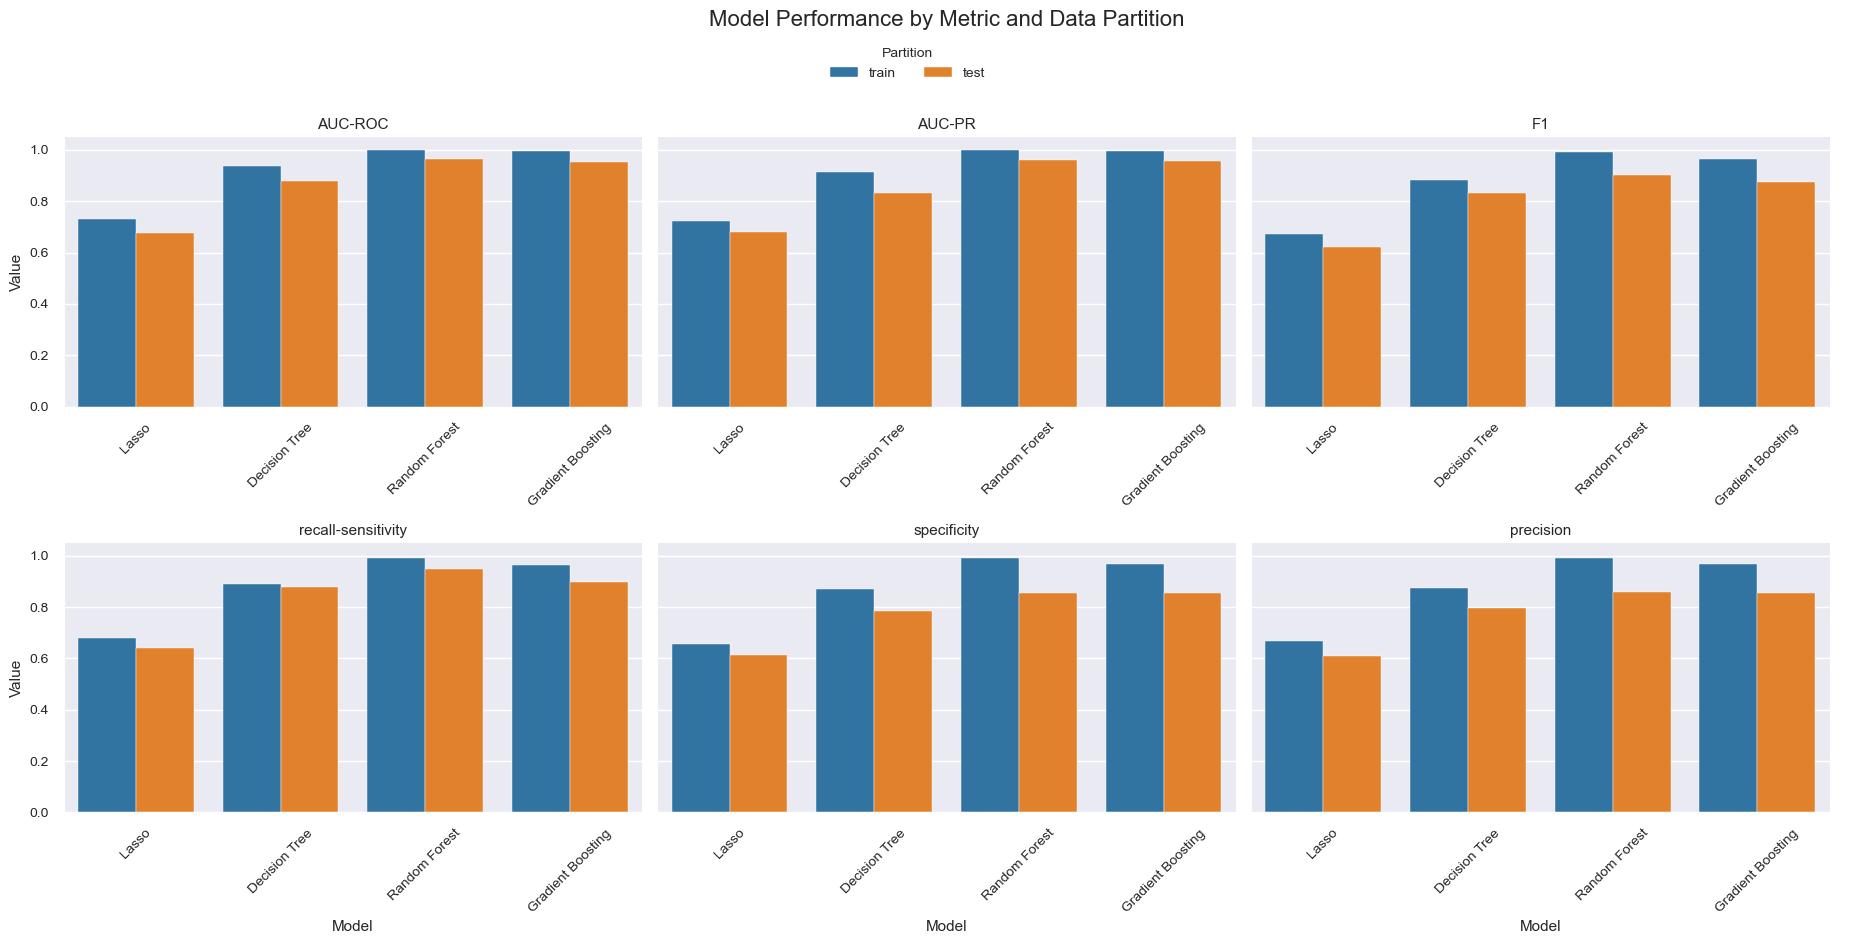

In [11]:
results_df = get_results_df(results)
plot_performance_metrics(results_df)

In [12]:
# dict of model names and classifiers for plotting curves
models = {
    "Lasso": lasso,
    "Decision Tree": dt,
    "Random Forest": rf,
    "Gradient Boosting": gb
}

# data
data = (X_train, X_test, y_train, y_test)

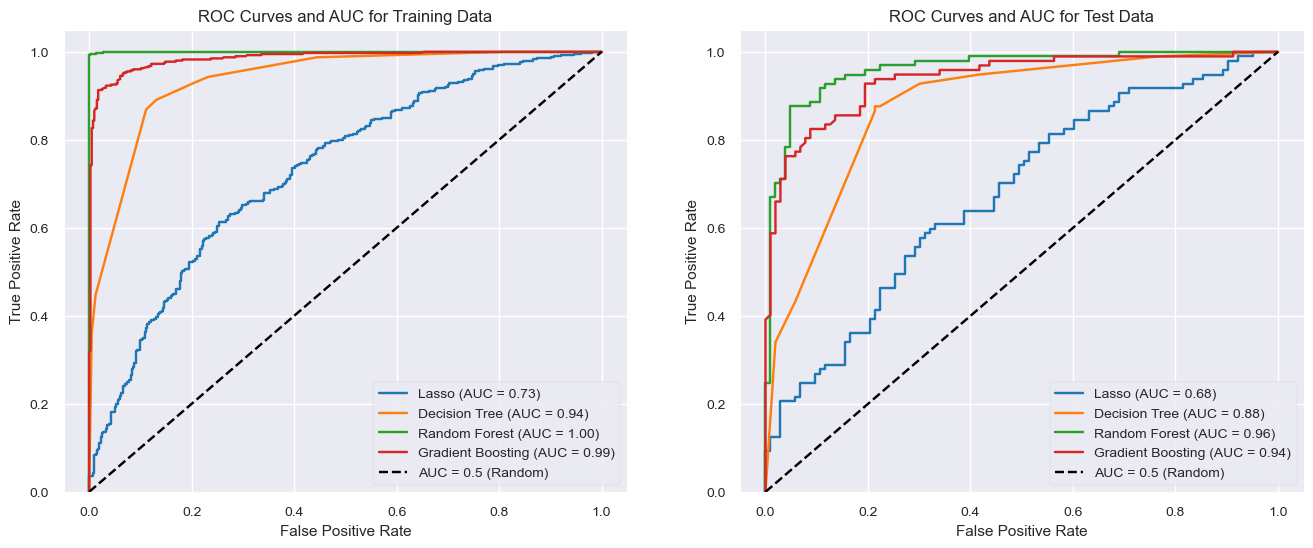

In [13]:
# ROC Curve
plot_ROC_curves(models, data)

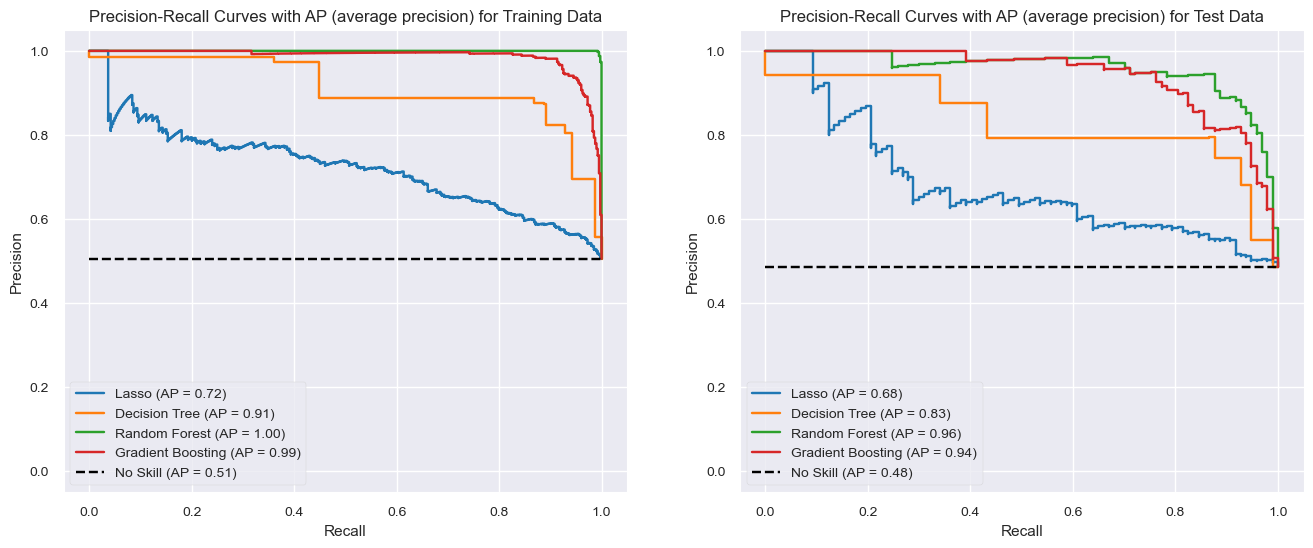

In [14]:
# Precision Recall Curve
plot_PR_curves(models, data)

<a name="5.3.-Variable-Importance"></a>
## 5.3 Variable Importance

[Return to top](#Notebook-Contents)

<a name="6.-Conclusions"></a>
# 6. Conclusions

[Return to top](#Notebook-Contents)

We found this project to be both interesting and quite challenging. Blah blah blah.

Perhaps the three most perplexing issues we encountered were:

1. placeholder1 

2. placeholder2

3. placeholder3

<a name="6.1.-Patient-Early-Readmittance-Rate"></a>
## 6.1 Patient Early Readmittance Rate

[Return to top](#Notebook-Contents)

<a name="6.2.-Patient-Risk-Profiles"></a>
## 6.2 Patient Risk Profiles

[Return to top](#Notebook-Contents)

<a name="7.-Future-Work"></a>
# 7. Future Work

[Return to top](#Notebook-Contents)

In our analysis of the Chest X-ray dataset we have tried a variety of modeling and feature engineering approaches, but there are still several additional steps that could be taken:

1. placeholder1

2. placeholder2

3. placeholder2

<a name="8.-References"></a>
# 8. References

[Return to top](#Notebook-Contents)

**The following are links to papers, blogs, and tutorials we found useful during the development of this project:**

Fine-tuning for transfer learning models:
https://keras.io/guides/transfer_learning/

Medical neural networks:
https://glassboxmedicine.com/

Image classification using CNNs:
https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a

Comparison of ResNet50 and VGG19 and training from stratch for X-ray images dataset:
https://www.sciencedirect.com/science/article/pii/S2666285X21000558

Tensorflow Applications for base model:
https://keras.io/api/applications/

Tensorboard confusion matrix:
https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12

Pre-processing and modeling pipelines (ResNet50):
https://towardsdatascience.com/time-to-choose-tensorflow-data-over-imagedatagenerator-215e594f2435

Image data input pipelines:
https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5

Split TF datasets:
https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

Transfer learning with EfficientNet:
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

Training greyscale images using transfer learning:
https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images

Multi-label vs multi-class classification:
https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/

Multi-label classification example use-case:
https://towardsdatascience.com/fast-ai-season-1-episode-3-a-case-of-multi-label-classification-a4a90672a889

Element-wise sigmoid:
https://www.programcreek.com/python/example/93769/keras.backend.sigmoid

Element-wise sigmoid:
https://stackoverflow.com/questions/52090857/how-to-apply-sigmoid-function-for-each-outputs-in-keras

DenseNet121:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8189817/